In [99]:
import sys, time
import os #os.chdir("dir with *.m files")
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KernelDensity
from pyentropy import DiscreteSystem
import scipy.stats as stats

import warnings

sns.set(style='ticks',font_scale=1.5)

In [2]:
import spikeextractors as se
import kachery as ka
ka.set_config(fr='default_readonly')

In [3]:
#this should be updated 
SF = ka.load_object('sha1://1667383039f1170256e4e3445d46eff367e202e5/output.json', fr='default_readonly')
sorting_results = SF['SortingResults']

In [5]:
GT = ka.load_object(sorting_results[0]['comparisonWithTruth']['json'],fr='default_readonly') 
#? when printed, GT is none

In [97]:
gt_path_kampff = {'c26':'sha1dir://51570fce195942dcb9d6228880310e1f4ca1395b.paired_kampff/c26/firings_true.mda',
           'c46':'sha1dir://51570fce195942dcb9d6228880310e1f4ca1395b.paired_kampff/c46/firings_true.mda',
           'c28':'sha1dir://51570fce195942dcb9d6228880310e1f4ca1395b.paired_kampff/c28/firings_true.mda',
            'c45':'sha1dir://51570fce195942dcb9d6228880310e1f4ca1395b.paired_kampff/c45/firings_true.mda',
             '2015_09_03_Pair_9_0A':'sha1dir://51570fce195942dcb9d6228880310e1f4ca1395b.paired_kampff/2015_09_03_Pair_9_0A/firings_true.mda',
             '2015_09_03_Pair_9_0B':'sha1dir://51570fce195942dcb9d6228880310e1f4ca1395b.paired_kampff/2015_09_03_Pair_9_0B/firings_true.mda'}

gt_path_boyden = {'915_10_1':'sha1dir://49b1fe491cbb4e0f90bde9cfc31b64f985870528.paired_boyden32c/915_10_1/firings_true.mda',
           '915_18_1':'sha1dir://49b1fe491cbb4e0f90bde9cfc31b64f985870528.paired_boyden32c/915_18_1/firings_true.mda',
           '915_8_1':'sha1dir://49b1fe491cbb4e0f90bde9cfc31b64f985870528.paired_boyden32c/915_8_1/firings_true.mda',
            '531_2_1':'sha1dir://49b1fe491cbb4e0f90bde9cfc31b64f985870528.paired_boyden32c/531_2_1/firings_true.mda',
             '419_1_7':'sha1dir://49b1fe491cbb4e0f90bde9cfc31b64f985870528.paired_boyden32c/419_1_7/firings_true.mda',
             '419_1_8':'sha1dir://49b1fe491cbb4e0f90bde9cfc31b64f985870528.paired_boyden32c/419_1_8/firings_true.mda'}

gt_path_english = {#'m113_191125_213423':'sha1://249d20297e123fa3dca09e7cda1a78664944ae28/firings_true.json',
           'm15_190315_152315_cell1':'sha1://9f15a4ee3db2d18b6a3b3e0ad632e5d9764cd37f/firings_true.json',
           'm14_190326_160710_cell1':'sha1://b56d170dc6019d81e41f5a171d5f50e677eaed71/firings_true.json',
            'm139_200114_222743':'sha1://b56d170dc6019d81e41f5a171d5f50e677eaed71/firings_true.json'}

best_unitid_kampff = {'c26':8, 'c46':14, 'c28':10, 'c45':13, '2015_09_03_Pair_9_0A':1, '2015_09_03_Pair_9_0B':2}
best_unitid_boyden = {'915_10_1':15, '915_18_1':17, '531_2_1':9, '915_8_1':18, '419_1_7':1, '419_1_8':2}
best_unitid_english = {'m113_191125_213423':3, 'm15_190315_152315_cell1':17, 'm14_190326_160710_cell1':13, 'm139_200114_222743':10}

In [7]:
def calculate_entropies(sorting, method, word_length, sampling_frequency, binSec=0.005):
    output = np.zeros((len(sorting.get_unit_ids())))
    
    sampF = sampling_frequency
    wLen = word_length
    unit_ids = sorting.get_unit_ids()
    fr = np.zeros(len(unit_ids))
    isi = [[] for uid in unit_ids]
    spike_trains = [sorting.get_unit_spike_train(unit_id=uid) for uid in unit_ids]
    maxT = np.max([np.max(st) for st in spike_trains]) / sampling_frequency
    for ii, unit_id in enumerate(unit_ids):
        spk = spike_trains[ii]
        fr[ii] = len(spk)/maxT
        isi[ii] = np.diff(spk)/sampF
        binSize = binSec * sampF 
        bins = np.arange(0, maxT*sampF, binSize)
        spkCount,_ = np.histogram(spk, bins)
        spkCount[spkCount>1] = 1 #digitising spike train
            
        i = 0
        words = None
        while i<len(spkCount)-wLen:
            if words is None:
                words = spkCount[i:i+wLen]
                i += wLen #increase counter by wLen
            else:
                words = np.vstack((words,spkCount[i:i+wLen]))
                i += wLen
        response = np.zeros(words.shape[0]).astype(int)
        xm = np.max(spkCount)+1
        # todo: this line only applies to a subset of the methods
        sys = DiscreteSystem(words.T.astype(int), (wLen,xm), response, (1,1))
        if method == 'plugin':
            sys.calculate_entropies(method='plugin', calc=['HX'])
            output[ii] = sys.H_plugin['HX']
        elif method == 'pt':
            sys.calculate_entropies(method='pt', calc=['HX'])
            output[ii] = sys.H_pt['HX']
        elif method == 'qe':
            sys.calculate_entropies(method='qe', calc=['HX'])
            output[ii] = sys.H_qe['HX']
        elif method == 'CDM':
            output[ii] = eng.entropyCDM(matlab.double(words.tolist()), 0)
    return output, fr, isi

In [87]:
def calculate_entropies_counts_t(sorting, method, sampling_frequency, binSec=0.5, NT=60):
        
        sampF = sampling_frequency
        unit_ids = sorting.get_unit_ids()
        isi = [[] for uid in unit_ids]
        spike_trains = [sorting.get_unit_spike_train(unit_id=uid) for uid in unit_ids]
        maxT = np.max([np.max(st) for st in spike_trains]) / sampling_frequency
        nTS =  np.floor(maxT/(binSec*NT)-1).astype(int)
        fr = np.zeros((len(unit_ids),nTS))
        output = np.zeros((len(sorting.get_unit_ids()),nTS))
        for ii, unit_id in enumerate(unit_ids):
            spk = spike_trains[ii]
            isi[ii] = np.diff(spk)/sampF
            binSize = binSec * sampF 
            bins = np.arange(0, maxT*sampF, binSize)
            spkCount,_ = np.histogram(spk, bins)
            start = 0
            for nn,n in enumerate(np.linspace(NT,len(spkCount),nTS).astype(int)):
                spkCount_ = spkCount[start:n]
                fr[ii,nn] = np.mean(spkCount_)/binSec
                start = n
                xm = np.max(spkCount_)+1
                sys = DiscreteSystem(spkCount_.astype(int), (1,xm), spkCount_, (1,xm))        
                if method == 'plugin':
                    sys.calculate_entropies(method='plugin', calc=['HX'])
                    output[ii,nn] = sys.H_plugin['HX']
                elif method == 'pt':
                    sys.calculate_entropies(method='pt', calc=['HX'])
                    output[ii,nn] = sys.H_pt['HX']
                elif method == 'qe':
                    sys.calculate_entropies(method='qe', calc=['HX'])
                    output[ii,nn] = sys.H_qe['HX']
            #elif method == 'CDM':
                #output[ii] = eng.entropyCDM(matlab.double(spkCount.tolist()), 0)
        return output, fr, isi

In [8]:
def calculate_entropies_counts(sorting, method, sampling_frequency, binSec=0.3):
    output = np.zeros((len(sorting.get_unit_ids())))
    
    sampF = sampling_frequency
    unit_ids = sorting.get_unit_ids()
    fr = np.zeros(len(unit_ids))
    isi = [[] for uid in unit_ids]
    spike_trains = [sorting.get_unit_spike_train(unit_id=uid) for uid in unit_ids]
    maxT = np.max([np.max(st) for st in spike_trains]) / sampling_frequency
    for ii, unit_id in enumerate(unit_ids):
        spk = spike_trains[ii]
        fr[ii] = len(spk)/maxT
        isi[ii] = np.diff(spk)/sampF
        binSize = binSec * sampF 
        bins = np.arange(0, maxT*sampF, binSize)
        spkCount,_ = np.histogram(spk, bins)
            
        xm = np.max(spkCount)+1
        sys = DiscreteSystem(spkCount.astype(int), (1,xm), spkCount, (1,xm))        
        if method == 'plugin':
            sys.calculate_entropies(method='plugin', calc=['HX'])
            output[ii] = sys.H_plugin['HX']
        elif method == 'pt':
            sys.calculate_entropies(method='pt', calc=['HX'])
            output[ii] = sys.H_pt['HX']
        elif method == 'qe':
            sys.calculate_entropies(method='qe', calc=['HX'])
            output[ii] = sys.H_qe['HX']
        #elif method == 'CDM':
            #output[ii] = eng.entropyCDM(matlab.double(spkCount.tolist()), 0)
    return output, fr, isi

In [96]:
def poisson_spk_entropy(fr,binSec,N):
    x = np.random.poisson(fr*binSec,N)
#     print(fr,np.mean(x)/binSec)
    xm = np.max(x)+1
    sys = DiscreteSystem(x.astype(int), (1,xm), x, (1,xm))
    sys.calculate_entropies(method='pt', calc=['HX'])
    return sys.H_pt['HX']

def run_poisson_spkH_samples(fr,binSec,N,R):
    out = np.zeros(R)
    for r in range(R):
        out[r] = poisson_spk_entropy(fr,binSec,N)
    return np.mean(out)

In [ ]:
def calculate_mi_gt(sorting, gt_path, method, sampling_frequency, binSec=0.1):
    output = np.zeros((len(sorting.get_unit_ids())))
    sampF = sampling_frequency
    binSize = binSec * sampF 
    # sorted units loading
    unit_ids = sorting.get_unit_ids()
    spike_trains = [sorting.get_unit_spike_train(unit_id=uid) for uid in unit_ids]
    # gt loading
    path_temp=ka.load_file(gt_path)
    gt_sort = se.MdaSortingExtractor(path_temp)
    unit_ids_gt = gt_sort.get_unit_ids()
    spk_gt = gt_sort.get_units_spike_train(unit_ids_gt)
    maxT = np.max([np.max(st) for st in spike_trains]) / sampling_frequency
    bins = np.arange(0, maxT*sampling_frequency, binSize)
    spkCount_gt,_ = np.histogram(spk_gt, bins)
    ym = np.max(spkCount_gt)+1
    for ii, unit_id in enumerate(unit_ids):
        spk = spike_trains[ii]
        bins = np.arange(0, maxT*sampF, binSize)
        spkCount,_ = np.histogram(spk, bins)
        xm = np.max(spkCount)+1
        # MI calculation
        sys = DiscreteSystem(spkCount.astype(int), (1,xm), spkCount_gt, (1,ym))        
        sys.calculate_entropies(method=method, calc=['HX','HY','HXY'])
        output[ii] = sys.I(); hy = sys.H_pt['HY']
    return [output,hy]

In [7]:
sorting_results = SF['SortingResults']
len(sorting_results[0]),len(sorting_results)
firings_path = ka.load_file(sorting_results[0]['firings'])
sorting = se.MdaSortingExtractor(firings_path)

In [8]:
sorters_ = []; recs = []
ref_study = 'paired_kampff'
for i in sorting_results:
    if i['studyName']==ref_study:
        sorters_.append(i['sorterName'])
        recs.append(i['recordingName'])
sorters_ = np.asarray(sorters_)
sorters = np.unique(sorters_)
recs_names = np.unique(recs)
for n in np.unique(sorters):
    print(n,'\t',sum(sorters_==n))

HerdingSpikes2 	 15
IronClust 	 15
JRClust 	 15
KiloSort 	 15
KiloSort2 	 15
MountainSort4 	 15
SpykingCircus 	 15
Tridesclous 	 15


In [ ]:
output_sort = {} #dictionary
bias = ['pt'] #list - better
FR = {}; ISI = {}
for y in bias:
    all_methods = {k:{} for k in sorters}
    fr = {k:{} for k in sorters}
    isi = {k:{} for k in sorters}
    for k in sorters:
        all_methods[k] = {kk:[] for kk in recs_names}
        fr[k] = {kk:[] for kk in recs_names}
        isi[k] = {kk:[] for kk in recs_names}
    print(y)
    for x in range(len(sorting_results)):
        if sorting_results[x]['studyName']==ref_study:
            try:
                firings_path = ka.load_file(sorting_results[x]['firings'])
                sort_temp = sorting_results[x]['sorterName']
                rec_temp = sorting_results[x]['recordingName']
                sorting = se.MdaSortingExtractor(firings_path)
                all_methods[sort_temp][rec_temp], fr[sort_temp][rec_temp], isi[sort_temp][rec_temp] =\
                    calculate_entropies(sorting, method=y, word_length=10, sampling_frequency=30000,
                                       binSec=0.005)
            except:
                print('exception: iteration %s'%x)
    output_sort[y]= all_methods
    FR[y] = fr; ISI[y] = isi

pt
exception: iteration 18
exception: iteration 19
exception: iteration 20
exception: iteration 21
exception: iteration 22
exception: iteration 23
exception: iteration 24
exception: iteration 25
exception: iteration 26
exception: iteration 27
exception: iteration 28
exception: iteration 29
exception: iteration 30
exception: iteration 31
exception: iteration 32
exception: iteration 429
exception: iteration 430
exception: iteration 431
exception: iteration 432
exception: iteration 433
exception: iteration 434
exception: iteration 435
exception: iteration 436
exception: iteration 437
exception: iteration 438
exception: iteration 439
exception: iteration 440
exception: iteration 441
exception: iteration 442
exception: iteration 443
exception: iteration 1288
exception: iteration 1289
exception: iteration 1290
exception: iteration 1291
exception: iteration 1292
exception: iteration 1293
exception: iteration 1294
exception: iteration 1295
exception: iteration 1296
exception: iteration 1297
ex

In [90]:
output_sort_c = {} #dictionary
bias = ['pt'] #list - better
FR_c = {}; ISI_c = {}
HF_c = {}
for y in bias:
    temp_out = {k:{} for k in sorters}
    all_methods = {k:{} for k in sorters}
    fr = {k:{} for k in sorters}
    isi = {k:{} for k in sorters}
    for k in sorters:
        temp_out[k] = {kk:[] for kk in recs_names}
        all_methods[k] = {kk:[] for kk in recs_names}
        fr[k] = {kk:[] for kk in recs_names}
        isi[k] = {kk:[] for kk in recs_names}
    print(y)
    for x in range(100):
        if sorting_results[x]['studyName']==ref_study:
            try:
                firings_path = ka.load_file(sorting_results[x]['firings'])
                sort_temp = sorting_results[x]['sorterName']
                rec_temp = sorting_results[x]['recordingName']
                sorting = se.MdaSortingExtractor(firings_path)
                all_methods[sort_temp][rec_temp], fr[sort_temp][rec_temp], isi[sort_temp][rec_temp] =\
                    calculate_entropies_counts_t(sorting, method=y, sampling_frequency=30000,
                                       binSec=0.3)
                for i in range(len(all_methods[sort_temp][rec_temp])):
                    nSpike = len(isi[sort_temp][rec_temp][i])+1;
                    FR_spk = np.mean(fr[sort_temp][rec_temp][i]);
                    H_poiss = run_poisson_spkH_samples(FR_spk,0.3,nSpike,10)                    
                    temp_out[sort_temp][rec_temp].append(
                        all_methods[sort_temp][rec_temp][i]/H_poiss)  
            except:
                print('exception: iteration %s'%x)
    HF_c[y] = temp_out
    output_sort_c[y]= all_methods
    FR_c[y] = fr; ISI_c[y] = isi

pt


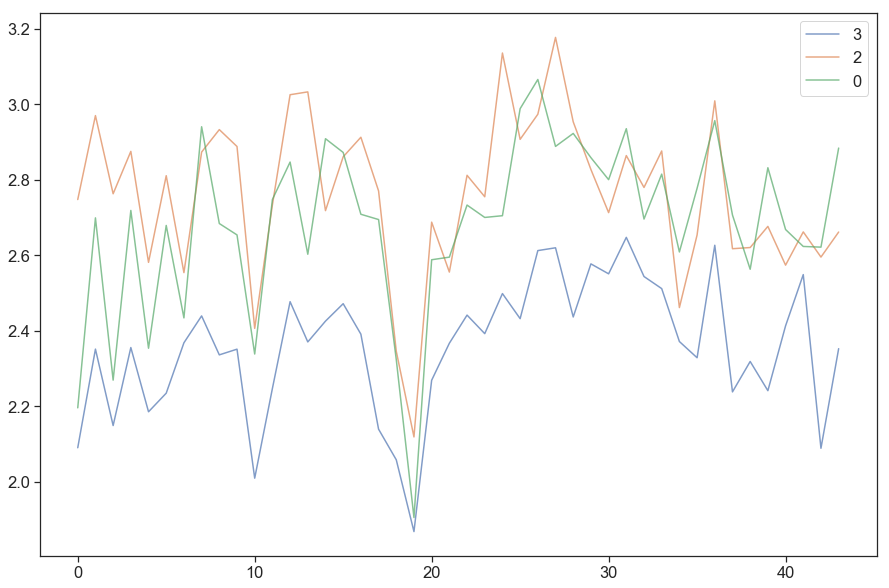

In [92]:
plt.figure(figsize=(15,10))
indx = np.argsort(out_mi[sort_temp][rec_temp])[-3:]
for n in indx:
    plt.plot(output_sort_c['pt'][sort_temp][rec_temp][n], alpha=.7, label=n)
plt.legend()


In [98]:
### Obtain GT entropy values
a = []
ref_study_gt = gt_path_kampff.keys()
out_mi = {k:{} for k in sorters}; gt_mi = {}
for x in range(100):
    if sorting_results[x]['recordingName'] in ref_study_gt:
        try:
            firings_path = ka.load_file(sorting_results[x]['firings'])
            sort_temp = sorting_results[x]['sorterName']
            rec_temp = sorting_results[x]['recordingName']
            a.append(rec_temp)
            sorting = se.MdaSortingExtractor(firings_path)
            out_mi[sort_temp][rec_temp], gt_mi[rec_temp] = calculate_mi_gt(sorting,gt_path_kampff[rec_temp], method='pt', sampling_frequency=30000,
                               binSec=0.3)
        except: pass

/usr/local/lib/python3.7/site-packages/pyentropy/utils.py:155: RuntimeWarning: invalid value encountered in double_scalars
  gamma = xtr*(1.0 - ((Nt/(Nt+Rnaive))**(1.0/Nt)))
/usr/local/lib/python3.7/site-packages/pyentropy/utils.py:155: RuntimeWarning: divide by zero encountered in double_scalars
  gamma = xtr*(1.0 - ((Nt/(Nt+Rnaive))**(1.0/Nt)))


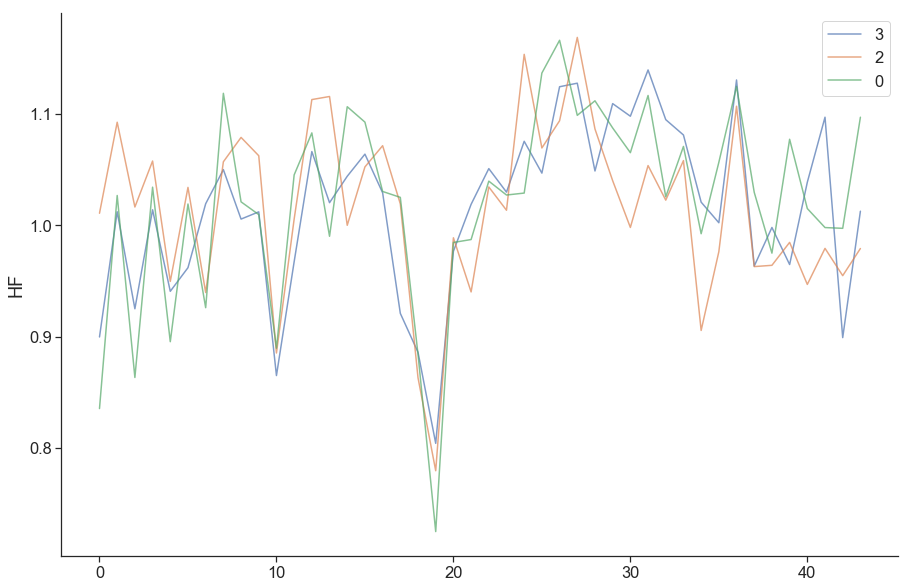

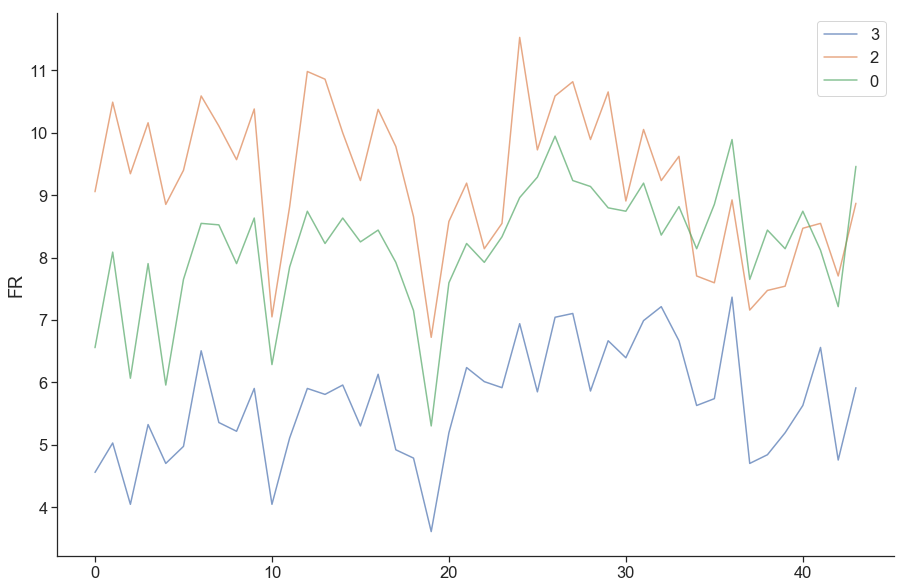

In [95]:
plt.figure(figsize=(15,10))
indx = np.argsort(out_mi[sort_temp][rec_temp])[-3:]
for n in indx:
    plt.plot(HF_c['pt'][sort_temp][rec_temp][n], alpha=.7, label=n)
plt.legend()
plt.ylabel('HF')
sns.despine()

plt.figure(figsize=(15,10))
for n in indx:
    plt.plot(FR_c['pt'][sort_temp][rec_temp][n], alpha=.7, label=n)
plt.legend()
plt.ylabel('FR')
sns.despine()

# all units/recording

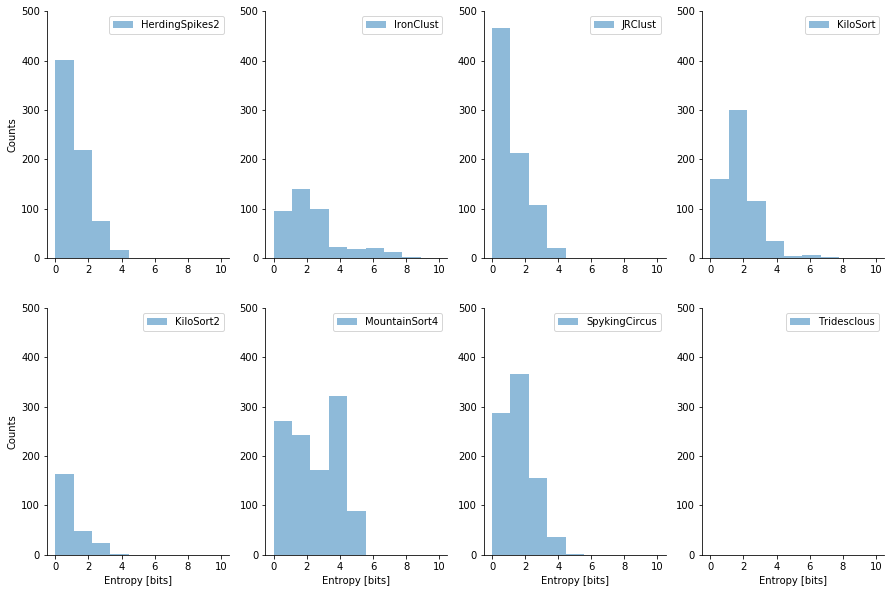

In [9]:
b = 'pt'
toP = {k:[] for k in sorters}
for s in sorters:
    for rr in recs_names:
        toP[s].extend(np.asarray(output_sort_c[b][s][rr]))
        
bins = np.linspace(0,10,10)
ri = 1 # recording index
plt.figure(figsize=(15,10))
for n,s in enumerate(sorters):
    plt.subplot(2,4,n+1)
    plt.hist(toP[s], bins=bins, label=s, alpha=0.5)
    plt.legend()
    sns.despine()
    plt.ylim(0,500)
    if n>3: plt.xlabel('Entropy [bits]')
    if n==0 or n==4: plt.ylabel('Counts')

In [26]:
a = []
ref_study_gt = gt_path_kampff.keys()
out_mi = {k:{} for k in sorters}; gt_mi = {}
for x in range(100):
    if sorting_results[x]['recordingName'] in ref_study_gt:
        try:
            firings_path = ka.load_file(sorting_results[x]['firings'])
            sort_temp = sorting_results[x]['sorterName']
            rec_temp = sorting_results[x]['recordingName']
            a.append(rec_temp)
            sorting = se.MdaSortingExtractor(firings_path)
            out_mi[sort_temp][rec_temp], gt_mi[rec_temp] = calculate_mi_gt(sorting,gt_path_kampff[rec_temp], method='pt', sampling_frequency=30000,
                               binSec=0.3)
        except: pass
print(np.unique(a))

['2015_09_03_Pair_9_0A' '2015_09_03_Pair_9_0B' 'c26' 'c28' 'c45' 'c46']


In [52]:
mi_score = {k:{} for k in sorters}; mi_id = {k:{} for k in sorters}
for s in sorters:
    for r in ref_study_gt:
        try:
            mi_score[s][r] = np.nanmax(out_mi[s][r]) / gt_mi[r]
            mi_id[s][r] = np.argmax(out_mi[s][r])
        except: mi_score[s][r] = np.nan; mi_id[s][r] = np.nan 

HerdingSpikes2 0.9379935268508658 0.6824288136447615
IronClust 0.9443237094226397 0.8617082747771433
JRClust 0.923673444812397 0.8559850479420771
KiloSort 0.9792959925552472 0.8854786489526204
KiloSort2 0.001253295539050194 0.001253295539050194
MountainSort4 0.9413957665580075 0.766700730705376
SpykingCircus 0.9557285497468192 0.7710388084271654
Tridesclous nan nan


/Users/martyna/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: All-NaN axis encountered
  if __name__ == '__main__':
/Users/martyna/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: Mean of empty slice
  if __name__ == '__main__':


Text(0, 0.5, 'Mutual Information [bits]')

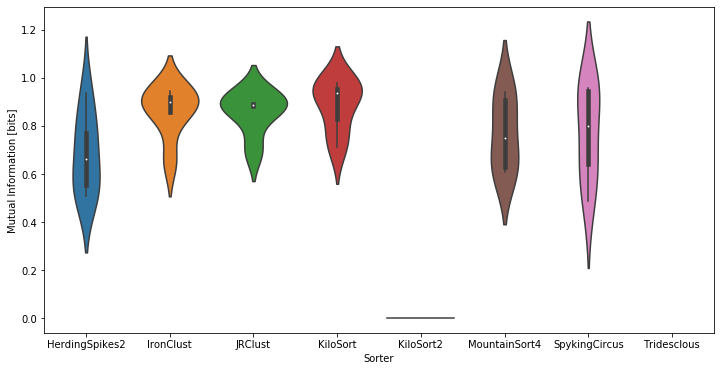

In [78]:
import seaborn as sns
import pandas as pd
df = pd.DataFrame()
fig = plt.figure(figsize=(12,6))
ax = plt.subplot(111)
for s in sorters:
    temp = [mi_score[s][r] for r in mi_score[s].keys()]
    df[s] = temp
    print(s,np.nanmax(temp), np.nanmean(temp))
sns.violinplot(data=df,ax=ax)
plt.xlabel('Sorter'); plt.ylabel('Mutual Information [bits]')

In [37]:
df

,HerdingSpikes2,IronClust,JRClust,KiloSort,KiloSort2,MountainSort4,SpykingCircus,Tridesclous
0,0.506982,0.655371,0.699438,0.793296,NaN,0.692022,0.487400,NaN
1,0.747931,0.891369,0.890552,0.941241,NaN,0.940496,0.924189,NaN
2,0.579145,0.847248,NaN,0.979296,NaN,0.941396,0.955729,NaN
3,0.777379,0.911073,0.880772,0.959201,NaN,0.810596,0.631451,NaN
4,0.545142,0.920865,0.885490,0.929605,NaN,0.606150,0.677579,NaN
5,0.937994,0.944324,0.923673,0.710233,0.001253,0.609545,0.949885,NaN


In [123]:
gt_features = {}
for d in gt_path_kampff.keys():
    gt_features[d] = {}
    path_temp=ka.load_file(gt_path_kampff[d])
    gt_features[d]['sorting'] = se.MdaSortingExtractor(path_temp)
    gt_features[d]['H'], gt_features[d]['FR'], gt_features[d]['ISI'] =\
        calculate_entropies(gt_features[d]['sorting'], method='pt', word_length=10, sampling_frequency=30000,
                                       binSec=0.05)

KeyError: 'm15_190315_152315_cell1'

In [343]:
gt_features_c = {}
for d in gt_path_kampff.keys():
    gt_features_c[d] = {}
    path_temp=ka.load_file(gt_path_kampff[d])
    gt_features_c[d]['sorting'] = se.MdaSortingExtractor(path_temp)
    gt_features_c[d]['H'], gt_features_c[d]['FR'], gt_features_c[d]['ISI'] =\
        calculate_entropies_counts(gt_features_c[d]['sorting'], method='pt', sampling_frequency=30000,
                                       binSec=0.3)
    nSpike = len(gt_features_c[d]['ISI'][0])+1
    fr_spk = gt_features_c[d]['FR']
    h_p = run_poisson_spkH_samples(fr_spk, 0.3, nSpike, 10)
    gt_features_c[d]['HF'] = gt_features_c[d]['H'] / h_p

In [344]:
for d in gt_path_kampff.keys():
    print(gt_features_c[d]['HF'])

[1.01106669]
[1.02350209]
[0.95837501]
[1.06980187]
[1.03752074]
[1.03801804]


ValueError: num must be 1 <= num <= 8, not 9

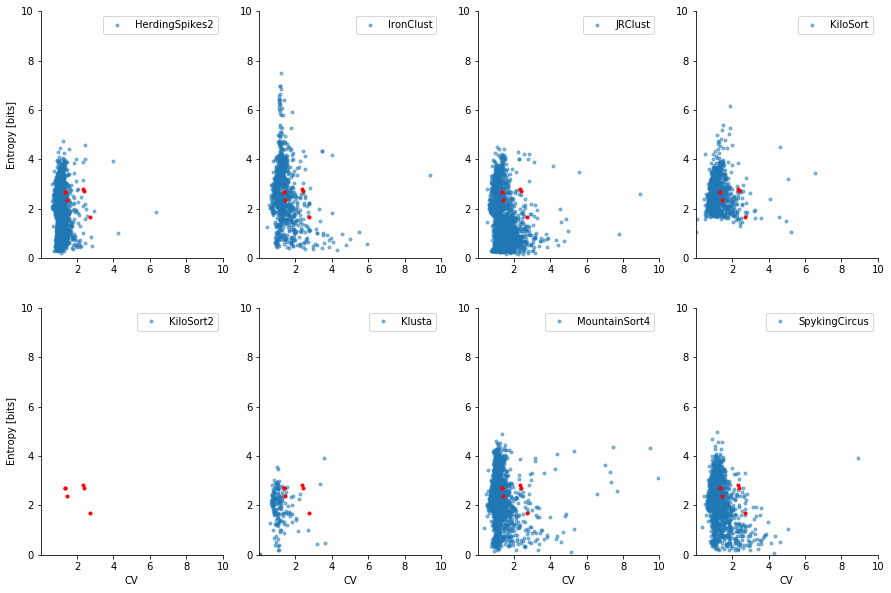

In [361]:
get_median = lambda isi: [np.median(isi[i]) for i in range(len(isi))]
get_cv = lambda isi: [np.std(isi[i])/np.mean(isi[i]) for i in range(len(isi))]

fr_gt = []; h_gt = []; isi_gt = []; cv_gt = []
for d in gt_features_c.keys():
    fr_gt.append(gt_features_c[d]['FR'])
    h_gt.append(gt_features_c[d]['H'])
    isi_gt.append(np.median(gt_features_c[d]['ISI']))
    cv_gt.append(np.std(gt_features_c[d]['ISI']) / np.mean(gt_features_c[d]['ISI']))    
b = 'pt'
toP = {k:[] for k in sorters}
toP2 = {k:[] for k in sorters}
for s in sorters:
    for rr in recs_names:
        toP[s].extend(np.asarray(output_sort_c[b][s][rr]))
        toP2[s].extend(np.asarray(get_cv(ISI_c[b][s][rr])))
bins = np.linspace(0,10,10)
ri = 1 # recording index
plt.figure(figsize=(15,10))
for n,s in enumerate(sorters):
    plt.subplot(2,4,n+1)
    plt.plot(toP2[s],toP[s], '.', label=s, alpha=0.5)
    plt.legend()
    sns.despine()
    plt.ylim(0,10); plt.xlim(0.001,1000)
#     if len(toP2[s])>0: plt.xscale('log')
    plt.plot(cv_gt,h_gt,'r.'); plt.xlim(0.01,10); plt.ylim(0,10)
    if n==0 or n==4: plt.ylabel('Entropy [bits]')
    if n>3: plt.xlabel('CV')    

In [375]:
HF_counts = {} #dictionary
bias = ['pt'] #list - better
binL = 0.3

for y in bias:
    temp_out = {k:{} for k in sorters}
    for k in sorters:
        temp_out[k] = {kk:[] for kk in recs_names}
    for x in range(len(sorting_results)):
        if sorting_results[x]['studyName']==ref_study:
            try:
                firings_path = ka.load_file(sorting_results[x]['firings'])
                sort_temp = sorting_results[x]['sorterName']
                rec_temp = sorting_results[x]['recordingName']
                sorting = se.MdaSortingExtractor(firings_path)
                for i in range(len(output_sort_c[y][sort_temp][rec_temp])):
                    nSpike = len(ISI_c[y][sort_temp][rec_temp][i])+1;
                    FR_spk = FR_c[y][sort_temp][rec_temp][i];
                    H_poiss = run_poisson_spkH_samples(FR_spk,binL,nSpike,10)                    
                    temp_out[sort_temp][rec_temp].append(output_sort_c[y][sort_temp][rec_temp][i]/H_poiss)                                        
            except:
                print('exception: iteration %s'%x)
    HF_counts[y] = temp_out

/Users/martyna/.local/lib/python3.7/site-packages/pyentropy/systems.py:574: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if (not np.issubdtype(X.dtype, np.int)) \
/Users/martyna/.local/lib/python3.7/site-packages/pyentropy/systems.py:575: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  or (not np.issubdtype(Y.dtype, np.int)):
/Users/martyna/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in double_scalars


exception: iteration 4516
exception: iteration 4517
exception: iteration 4518
exception: iteration 4519
exception: iteration 4520
exception: iteration 4521
exception: iteration 4522
exception: iteration 4523
exception: iteration 4524
exception: iteration 4525
exception: iteration 4526
exception: iteration 4527
exception: iteration 4528
exception: iteration 4529
exception: iteration 4530
exception: iteration 4531
exception: iteration 4532
exception: iteration 4533
exception: iteration 4534
exception: iteration 4535
exception: iteration 4536
exception: iteration 4537
exception: iteration 4538
exception: iteration 4539
exception: iteration 4540


/Users/martyna/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/martyna/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


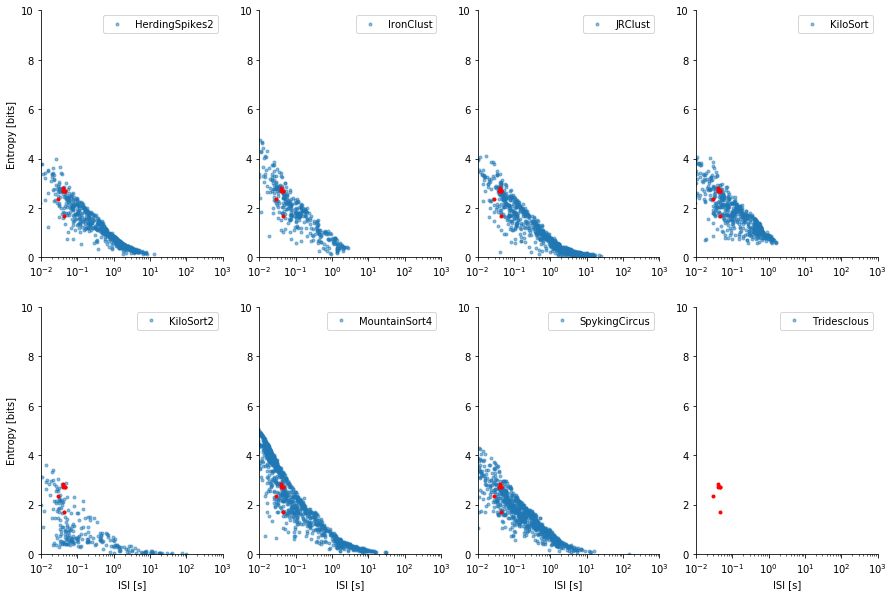

In [348]:
fr_gt = []; h_gt = []; isi_gt = []
for d in gt_features_c.keys():
    fr_gt.append(gt_features_c[d]['FR'])
    h_gt.append(gt_features_c[d]['H'])
    isi_gt.append(np.median(gt_features_c[d]['ISI']))
        
b = 'pt'
toP = {k:[] for k in sorters}
toP2 = {k:[] for k in sorters}
for s in sorters:
    for rr in recs_names:
        toP[s].extend(np.asarray(output_sort_c[b][s][rr]))
        toP2[s].extend(np.asarray(get_median(ISI_c[b][s][rr])))
bins = np.linspace(0,10,10)
ri = 1 # recording index
plt.figure(figsize=(15,10))
for n,s in enumerate(sorters):
    plt.subplot(2,4,n+1)
    plt.plot(toP2[s],toP[s], '.', label=s, alpha=0.5)
    plt.legend()
    sns.despine()
    plt.ylim(0,10); plt.xlim(0.001,1000)
    if len(toP2[s])>0: plt.xscale('log')
    plt.plot(isi_gt,h_gt,'r.'); plt.xscale('log'); plt.xlim(0.01,1000); plt.ylim(0,10)
    if n==0 or n==4: plt.ylabel('Entropy [bits]')
    if n>3: plt.xlabel('ISI [s]')
    

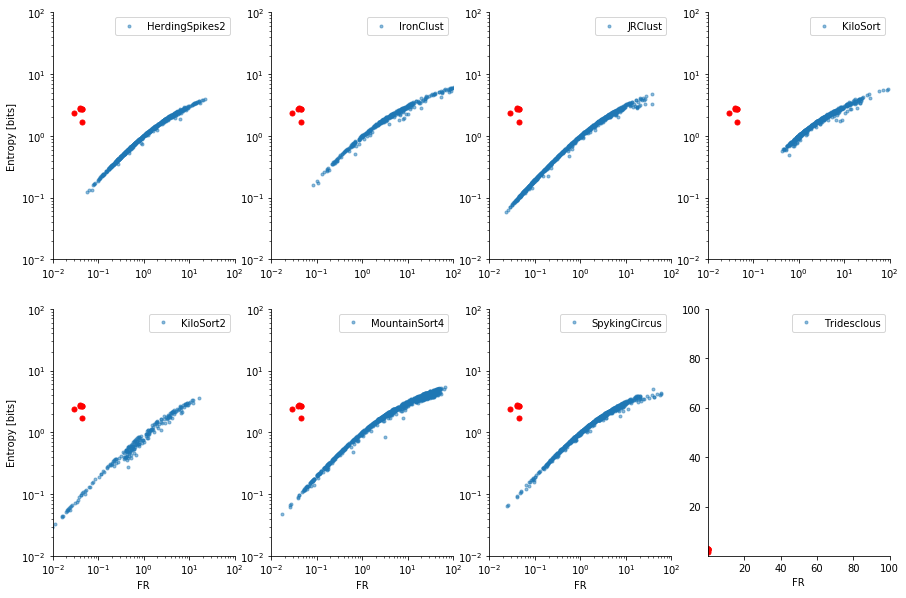

In [278]:
fr_gt = []; h_gt = []; isi_gt = []
for d in gt_features_c.keys():
    fr_gt.append(gt_features_c[d]['FR'])
    h_gt.append(gt_features_c[d]['H'])
    isi_gt.append(np.median(gt_features_c[d]['ISI']))
        
b = 'pt'
toP = {k:[] for k in sorters}
toP2 = {k:[] for k in sorters}
for s in sorters:
    for rr in recs_names:
        toP[s].extend(np.asarray(output_sort_c[b][s][rr]))
        toP2[s].extend(np.asarray(FR_c[b][s][rr]))
bins = np.linspace(0,10,10)
ri = 1 # recording index
plt.figure(figsize=(15,10))
for n,s in enumerate(sorters):
    plt.subplot(2,4,n+1)
    plt.plot(toP2[s],toP[s], '.', label=s, alpha=0.5)
    plt.legend()
    sns.despine()
    plt.ylim(0.01,100); plt.xlim(0.01,100)
    if len(toP2[s])>0: plt.xscale('log'); plt.yscale('log')
    plt.plot(isi_gt,h_gt,'r.',markersize=10)
   # plt.plot([0,100],[0,100], 'k--')
    if n==0 or n==4: plt.ylabel('Entropy [bits]')
    if n>3: plt.xlabel('FR')

/Users/martyna/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/martyna/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/martyna/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/martyna/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/martyna/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


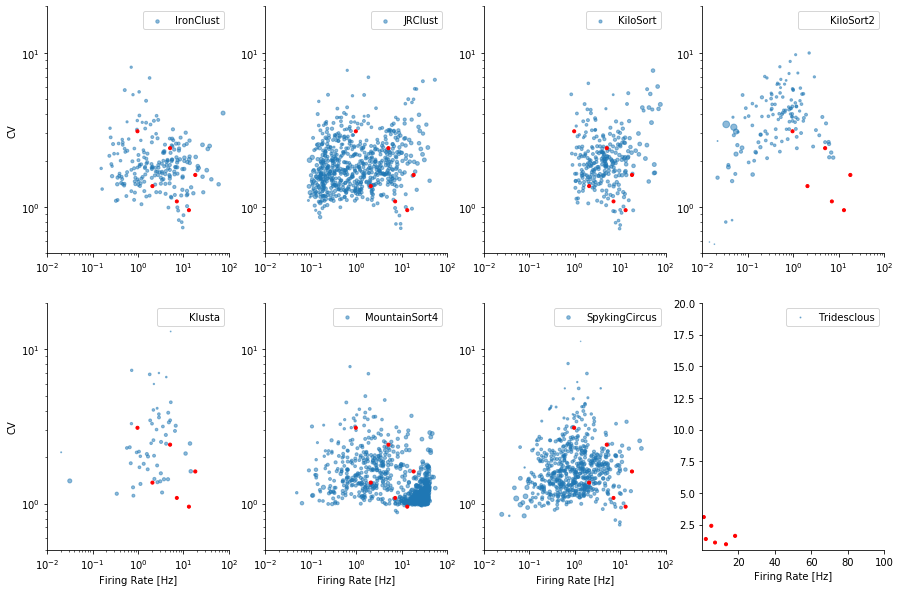

In [313]:
fr_gt = []; h_gt = []; isi_gt = []; hf_gt = []; cv_gt = []
for d in gt_features_c.keys():
    fr_gt.append(gt_features_c[d]['FR'])
    h_gt.append(gt_features_c[d]['H'])
    hf_gt.append(gt_features_c[d]['HF'])
    isi_gt.append(np.median(gt_features_c[d]['ISI']))
    cv_gt.append(np.std(gt_features_c[d]['ISI'])/np.mean(gt_features_c[d]['ISI']))
        
b = 'pt'
toP = {k:[] for k in sorters}
toP2 = {k:[] for k in sorters}
toP3 = {k:[] for k in sorters}
for s in sorters:
    for rr in recs_names:
        toP[s].extend(np.asarray(HF_counts[b][s][rr]))
        toP2[s].extend(np.asarray(FR_c[b][s][rr]))
        toP3[s].extend(get_cv(ISI_c[b][s][rr]))
bins = np.linspace(0,10,10)
ri = 1 # recording index
plt.figure(figsize=(15,10))
for n,s in enumerate(sorters):
    plt.subplot(2,4,n+1)
    plt.scatter(toP2[s],toP3[s], label=s, alpha=0.5, s=(3*np.array(toP[s]))**2)
    plt.legend()
    sns.despine()
    plt.ylim(0.5,20); plt.xlim(0.01,100)
    if len(toP3[s])>0: plt.xscale('log'); plt.yscale('log')
    plt.scatter(fr_gt,cv_gt,c='r',s=(3*np.array(hf_gt))**2)
    if n==0 or n==4: plt.ylabel('CV')
    if n>3: plt.xlabel('Firing Rate [Hz]')

/Users/martyna/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: Mean of empty slice
/Users/martyna/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/martyna/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/martyna/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/martyna/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/martyna/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/martyna/anaconda3

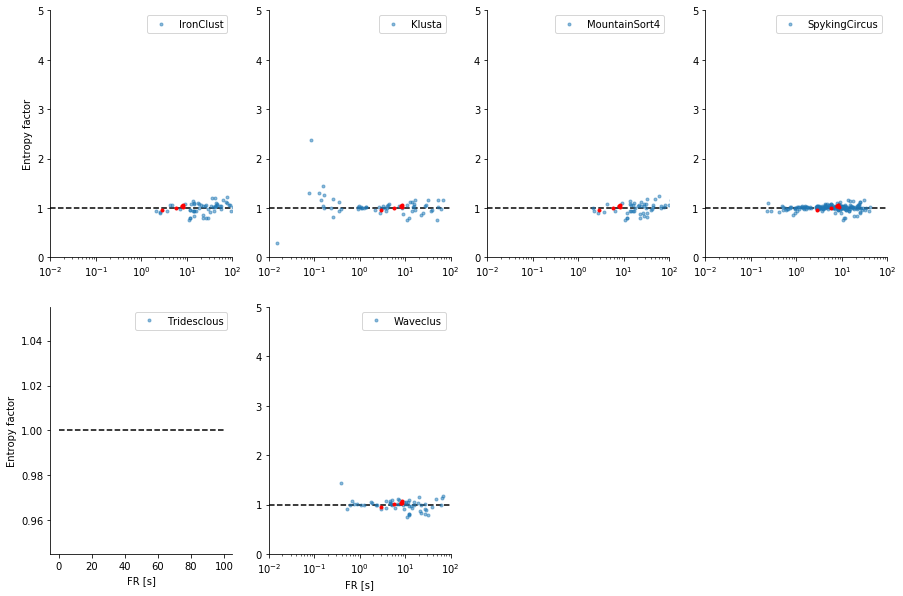

In [391]:
fr_gt = []; h_gt = []; isi_gt = []; hf_gt = [];
for d in gt_features_c.keys():
    fr_gt.append(gt_features_c[d]['FR'])
    h_gt.append(gt_features_c[d]['H'])
    isi_gt.append(np.median(gt_features_c[d]['ISI']))
    hf_gt.append(gt_features_c[d]['HF'])
        
binsLog = np.logspace(-2,2,15)
b = 'pt'
toP = {k:[] for k in sorters}
toP2 = {k:[] for k in sorters}
meanHF = {k:[] for k in sorters}
semHF = {k:[] for k in sorters}
for s in sorters:
    for rr in recs_names:
        toP[s].extend(np.asarray(HF_counts[b][s][rr]))
        toP2[s].extend(np.asarray(FR_c[b][s][rr]))
bins = np.linspace(0,10,10)
ri = 1 # recording index
plt.figure(figsize=(15,10))
for n,s in enumerate(sorters):
    plt.subplot(2,4,n+1)
    plt.plot(toP2[s],toP[s], '.', label=s, alpha=0.5)
    plt.legend()
    sns.despine()
    if len(toP2[s])>0: 
        plt.plot(fr_gt,hf_gt,'r.'); plt.xscale('log'); 
        plt.ylim(0,5); plt.xlim(0.01,100)
    if n==0 or n==4: plt.ylabel('Entropy factor')
    if n>3: plt.xlabel('FR [s]')
    for bi in range(len(binsLog)-1):
        temp = np.asarray(toP[s])[(toP2[s]>binsLog[bi]) & (toP2[s]<=binsLog[bi+1])]
        temp = temp[~np.isinf(temp)]
        meanHF[s].append(np.nanmean(temp))
        semHF[s].append(stats.sem(temp, nan_policy='omit'))
    meanHF[s] = np.asarray(meanHF[s])
    semHF[s] = np.asarray(semHF[s])
    plt.hlines(1,0.01,100,'k',linestyle='--')


Text(0, 0.5, 'HF [bits]')

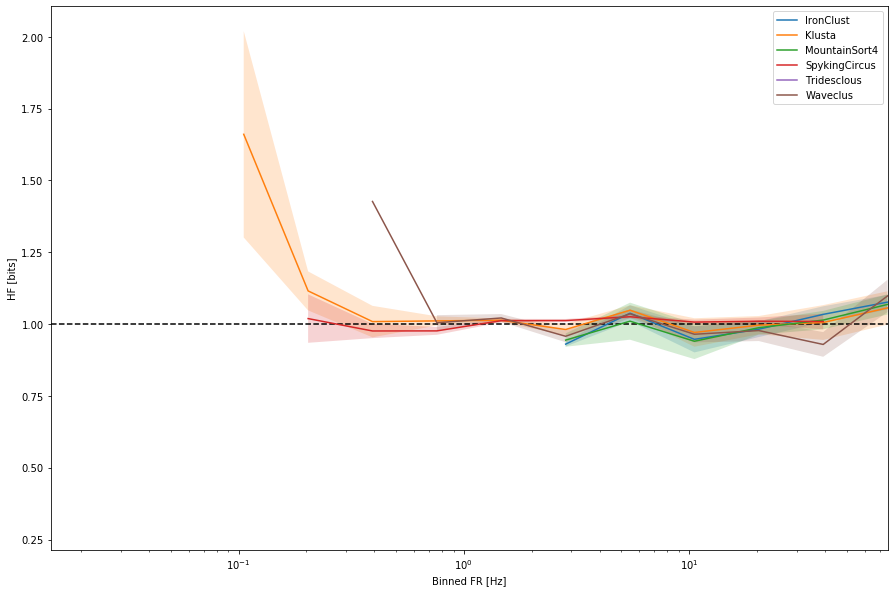

In [392]:
plt.figure(figsize=[15,10])
x2p = [(binsLog[i]+binsLog[i+1]) / 2 for i in range(len(binsLog)-1)]
for s in sorters:
    plt.plot(x2p, meanHF[s], label=s)
    plt.fill_between(x2p,meanHF[s]-semHF[s], meanHF[s]+semHF[s], alpha=.2)
plt.legend()
plt.xscale('log')
plt.hlines(1,x2p[0],x2p[-1],'k',linestyle='--')
plt.xlim(x2p[0], x2p[-1])
plt.xlabel('Binned FR [Hz]')
plt.ylabel('HF [bits]')

In [213]:
binsLog

array([1.00000000e-02, 6.30957344e-02, 3.98107171e-01, 2.51188643e+00,
       1.58489319e+01, 1.00000000e+02])

/Users/martyna/.local/lib/python3.7/site-packages/pyentropy/systems.py:574: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if (not np.issubdtype(X.dtype, np.int)) \
/Users/martyna/.local/lib/python3.7/site-packages/pyentropy/systems.py:575: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  or (not np.issubdtype(Y.dtype, np.int)):


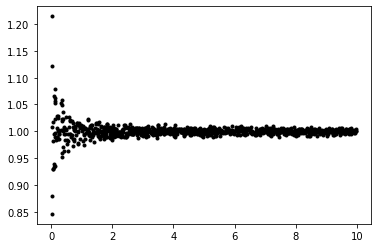

In [192]:
N = 1000
HF_poi = np.zeros(N)
fr2p = np.zeros(N)
nSpike = 10000
binL = 0.3
for i in range(N):
    frt = np.random.rand() * 10
    fr2p[i] = frt
    H_p = run_poisson_spkH_samples(frt,binL,nSpike,100)
    H_n = run_poisson_spkH_samples(frt,binL,nSpike,1)
    HF_poi[i] = H_n / H_p
plt.plot(fr2p, HF_poi, 'k.')